# Experiments with textual misinformation detection using machine learning models
In this experiment, we train and test machine learning models for detecting misinformation based purely on the text. We evaluated the performance of 5 classification models with wide use in text classification problems.

**Models:**
* Logistic regression
* Bernoulli Naive-Bayes
* Complementary Naive-Bayes
* Linear SVM with SGD training
* Linear SVM
* SVM
* KNN
* Random forest
* Gradient Boosting
* Multilayer Perceptron

# NOTES TO MYSELF

**To do:**
* ~~n-grams~~
* ~~tunning svm~~
* ~~combine bow and handcrafted features~~
* ~~handcrafted linguistic features~~
* ~~hyperparamater tunning; validation~~


**References:**
* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training


In [52]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")



## Experiments

## Subsets:
* Viral

# Feature engineering

### Vectorization
* bow: binary bag of words
* tfidf: term frequency–inverse document frequency

### N-grams
* unigram
* unigram-bigram
* unigram-bigram-trigram

### Limit features
* no limit
* max_features: limits to 500

### Pre-processing
* processed: convert url in just the domain, separate emojis, remove punctuation, downcase, lemmatization, remove stop words

### Conclusions:
* Smote is not the best oversampling technique for text, specially for BOW features
* Pre-processing the data didn't appear to have a great impact, despite the great reduction of dimentionality
* BOW features are comparably to TF-IDF features
* Random oversampling is a good oversampling technique
* Use a maximum number of features wasn't a good approach
* Better results are achivied when using unigrams, bigrams and trigrams



In [2]:
base = '2020'
subset = 'partial'
results_dir = 'results/' + str(base) + '/' + subset + '/ml/'
results_dir

'results/2020/partial/ml/'

In [102]:
df = pd.read_csv('data/2020/fakeWhatsApp.BR_2020_partial.csv')
df = df.dropna(subset=['misinformation'])
df = df[df['revision']!=0][['text','misinformation','shares']]
print(len(df))
df.head()

1690


,text,misinformation,shares
0,"O ministro da Ciência, Tecnologia, Inovações e...",0.0,27
1,Pesquisa com mais de 6.000 médicos em 30 paíse...,1.0,26
2,É com muita alegria que comunico que mais um p...,0.0,25
3,Renda Brasil unificará vários programas sociai...,0.0,25
4,O Secretário-Geral da OTAN Jens Stoltenberg ta...,0.0,24


In [103]:
#data_dir = 'data/' + str(base) #+ '/vis_processed_texts.p'
#filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
#df = pd.read_csv('data/2020/fakeWhatsApp.BR_2020_partial.csv')
#df = df[df['viral']==1]
#df = df[df['midia']==0]
#df = df[df['words']>50]
# print(len(df))
# df.head(5)   

In [104]:
# misinformation = list(df[df['misinformation']==1]['text'])
# misinformation = [preprocess(m,semi=True, rpunct = False, remoji = True) for m in misinformation]
# misinformation = ' '.join(misinformation)
# misinformation

In [105]:
# text_file = open('misinformation.txt','wt')
# text_file.write(misinformation)
# text_file.close()

# Let's take a look in the data

In [106]:
for m in df[df['misinformation']==1]['text'].unique()[0:5]:
    print()
    print(m)
    print()
    print('..................................')


Pesquisa com mais de 6.000 médicos em 30 países diz que hidroxicloroquina é o tratamento mais eficaz para coronavírus.

https://conexaopolitica.com.br/ultimas/pesquisa-com-mais-de-6-000-medicos-em-30-paises-diz-que-hidroxicloroquina-e-o-tratamento-mais-eficaz-para-coronavirus/amp/

..................................

China força países atingidos por vírus chinês a se ajoelharem diante da Huawei: “Nós lhe daremos máscaras se aceitar a Huawei 5G”

https://conexaopolitica.com.br/ultimas/china-forca-paises-atingidos-por-virus-chines-a-se-ajoelharem-diante-da-huawei-nos-lhe-daremos-mascaras-se-aceitar-a-huawei-5g/

..................................

Herança maldita: Mandetta renova contratos de publicidade de R$ 1bilhão firmados no governo Dilma 

De forma silenciosa e sem o aval do planalto, o ministro da saúde Luiz Henrique Mandetta renovou contratos de publiciade que ultrapassam R$ 1 bilhão com agências de publicidade que alimentam a mídia contra o presidente Jair Bolsonaro. 
Não é a t

In [107]:
for m in df[df['misinformation']==0]['text'].unique()[0:5]:
    print()
    print(m)
    print()
    print('..................................')


O ministro da Ciência, Tecnologia, Inovações e Comunicações, Marcos Pontes, afirmou, nesta terça-feira (9), que foram iniciados os novos testes com o vermífugo nitazoxanida em pacientes que tenham sido infectados pelo novo coronavírus. A novidade é que a partir de agora pacientes assintomáticos também serão testados. Basta ter a confirmação do coronavírus. O primeiro protocolo de testes trabalha com pessoas com febre e início de pneumonia, com o chamado “vidro fosco” na tomografia do pulmão.
https://dunapress.org/2020/06/11/governo-jair-bolsonaro-atraves-do-mctic-inicia-segundo-protocolo-de-testes-clinicos-com-a-nitazoxanida/

..................................

É com muita alegria que comunico que mais um pedido nosso relacionado ao Coronavírus foi atendido! O Ministério da Educação decidiu adiantar a formatura dos estudantes de Medicina, Enfermagem e outros cursos da área da Saúde para atuarem nos hospitais no enfrentamento da Covid-19! São mais de 10 mil universitários jovens e cor

# Corpus statistics

In [108]:
#df.describe()[['characters','words','sharings']]

data after remove duplicates


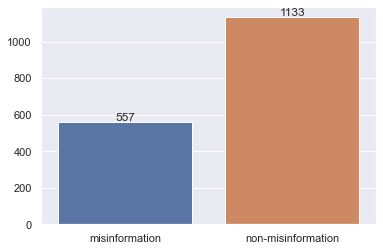

In [109]:
#removing duplicates    
df = df.drop_duplicates(subset=['text'])    
texts = df['text']
y = df['misinformation']

print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [110]:
print(len(texts))
print(len(y))

1690
1690


In [111]:
def avgSizeWords(string):
    list_string = string.split()
    chars = np.array([len(s) for s in list_string])
    return chars.mean()
df['text'] = [str(t).strip() for t in df['text']]
df['characters'] = [len(t) for t in df['text']]
df['words'] = [len(t.split()) for t in df['text']]
df['types'] = [len(set(t.split())) for t in df['text']]
df['types/token ratio'] = df['types']/df['words']
df['char/word ratio'] = df['characters']/df['words']
df['average chars by word'] = [avgSizeWords(t) for t in df['text']]
df[['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word', 'shares']].describe()

,words,types,types/token ratio,characters,char/word ratio,average chars by word,shares
count,1690.000,1690.000,1690.000,1690.000,1690.000,1690.000,1690.000
mean,106.610,69.517,0.885,749.586,28.488,27.678,2.259
std,244.522,124.307,0.140,1546.513,41.587,41.973,3.994
min,1.000,1.000,0.314,3.000,3.000,3.000,1.000
25%,8.000,8.000,0.802,112.000,6.120,5.101,1.000
50%,22.000,21.000,0.938,211.000,7.576,6.554,1.000
75%,88.000,71.000,1.000,614.500,15.647,14.625,2.000
max,4862.000,1718.000,1.000,31725.000,261.000,261.000,27.000


In [112]:
print('means by class')
mis = df[df['misinformation']==1][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','shares']].mean().to_frame().rename(columns={0: "misinformation"})
non_mis = df[df['misinformation']==0][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','shares']].mean().to_frame().rename(columns={0: "non-misinformation"})
mis.join(non_mis, lsuffix='_misinformation', rsuffix='_non-misinformation')

means by class


,misinformation,non-misinformation
words,173.181,73.883
types,108.131,50.534
types/token ratio,0.820,0.917
characters,1081.052,586.633
char/word ratio,7.732,38.692
average chars by word,6.699,37.991
shares,2.433,2.174


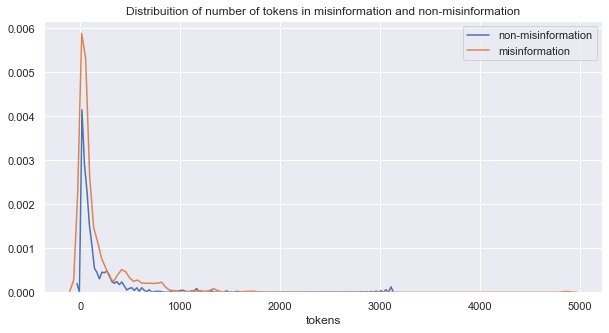

In [113]:
df['tokens'] = df['words']
plt.figure(figsize=(10, 5))
plt.title('Distribuition of number of tokens in misinformation and non-misinformation')
sns.distplot(df[df['misinformation']==0]['tokens'], hist = False, kde = True, label = 'non-misinformation')
sns.distplot(df[df['misinformation']==1]['tokens'], hist = False, kde = True, label = 'misinformation')
plt.show()

C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


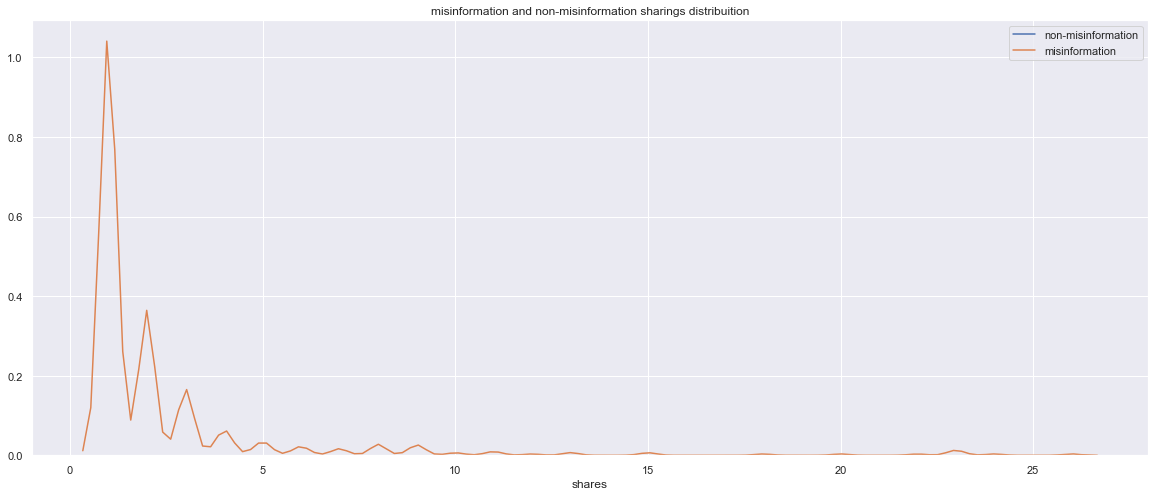

In [114]:
plt.figure(figsize=(20, 8))
plt.title('misinformation and non-misinformation sharings distribuition')
sns.distplot(df[df['misinformation']==0]['shares'], hist = False, kde = True, label = 'non-misinformation')
sns.distplot(df[df['misinformation']==1]['shares'], hist = False, kde = True, label = 'misinformation')
plt.show()

# Pre-processing
* convert url in just the domain
* separate emojis
* punctuation

[Some suggestions in this work](https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb)

* **Special character cleaning**

* **Upcase/downcase**

* **Punctuation signs** 

* **Possessive pronouns**

* **Stemming or Lemmatization**

* **Stop words**

In [115]:
#emojis and punctuation
emojis_list = list(emoji.UNICODE_EMOJI.keys())
emojis_list += ['\n']
punct = list(string.punctuation) + ['\n']
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = False, remove_emoji = False):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:
        
        if remove_punct: #remove punctuation            
            if c in punct: 
                text = text.replace(c, ' ')
        else: #put spaces between punctuation
            if c in punct:
                text = text.replace(c, ' ' + c + ' ')
        
        if remove_emoji: #remove emojis
            if c in emojis_list:
                text = text.replace(c, ' ')
        else: #put spaces between emojis
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')                        
            
    text = re.sub(' +', ' ', text)
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = re.sub(' +',' ',text)
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text
    

def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''    
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text
    
def processLoL(text):
    re_kkk = 'kkk*'
    t = re.sub(re_kkk, "kkk", text, flags=re.IGNORECASE)
    return t

def firstSentence(text):
    list_s = re.split('; |\. |\! |\? |\n',text)
    for s in list_s:
        if s is not None:
            return s
    

def preprocess(text,semi=False, rpunct = False, remoji = False, sentence = False):
    if sentence:
        text = firstSentence(text) # remove
    text = text.lower().strip()
    text = domainUrl(text)
    text = processLoL(text)
    text = processEmojisPunctuation(text, remove_punct = rpunct, remove_emoji = remoji)
    if semi:        
        return text
    text = removeStopwords(text)
    text = lemmatization(text)
    return text
           

In [116]:
# just first sentence
if 'sentence' in subset:
    df['pre_processed_text'] = [preprocess(t) for t in texts]
    df['semi_processed_text'] = [preprocess(t,semi=True) for t in texts]


In [117]:
df['pre_processed_text'] = [preprocess(t) for t in texts]
df['semi_processed_text'] = [preprocess(t,semi=True) for t in texts]
# df.to_csv('data/2018/fakeWhatsApp.BR_2018_processed.csv',index = False)

In [118]:
pro_texts = df['pre_processed_text']
semi_pro_texts = df['semi_processed_text']

def trucateText(text):
    words = text.split()
    if len(words) <= 100:
        return text
    else:
        words = words[0:100]
        text = ' '.join(words)
        return text

if 'trunc' in subset:
    pro_texts = [trucateText(t) for t in pro_texts]
    semi_pro_texts = [trucateText(t) for t in semi_pro_texts]
    

In [119]:
list(zip(pro_texts[100:120], semi_pro_texts[100:120]))

[(' 🔵 internet gratuito 500 gb 4g 🔵 causar epidemiar covid - 19 , oferecer 500 gb internet grátis , válido 90 dia ajudar - o ficar casarr ! * obter acesso gratuito internet ficar casarr * 👉 \n bit . ly',
  ' 🔵 internet gratuita de 500 gb 4g 🔵 por causa da epidemia de covid - 19 , oferecemos 500 gb de internet grátis , válidos por 90 dias para ajudá - lo a ficar em casa ! * obtenha acesso gratuito à internet e fique em casa * 👉 \n bit . ly'),
 (' * ficarr fácil responsabilizar culparr * \n \n * responsabilidade governar federal combater coronavírus , segundar stf ? * _ enviar recurso 💵 estar , certar ? _ \n \n * ser enviar * _ . . _ \n \n * qualquer outro fato relativo coronavírus , responsável : * _ governador prefeito . _ \n \n afinal , caber tomar decisão região . \n \n * ir : * \n \n * faltar dinheiro : * \n culpar governar federal ( mostrar , fascista , assassinar blá blá blá ) \n \n * aumentar número morte : * \n governador prefeito \n \n * faltar equipamento : * \n governador pre

In [120]:
print(len(pro_texts))
print(len(y))

1690
1690


# Experiments and models

In [121]:
vectorization = ['bow','tfidf']
ngrams = ['-unigram', '-unigram_bigram','-unigram_bigram_trigram']
processed = ['','-pre_processed']
max_features = ['']#,'-max_features']
balancing = ['','-oversampling']
experiments = []

for vec in vectorization:
    for ng in ngrams:
        for p in processed:
            for m in max_features:
                exp = vec+ng+p+m
                experiments.append(exp)

print(len(experiments))
experiments


12


['bow-unigram',
 'bow-unigram-pre_processed',
 'bow-unigram_bigram',
 'bow-unigram_bigram-pre_processed',
 'bow-unigram_bigram_trigram',
 'bow-unigram_bigram_trigram-pre_processed',
 'tfidf-unigram',
 'tfidf-unigram-pre_processed',
 'tfidf-unigram_bigram',
 'tfidf-unigram_bigram-pre_processed',
 'tfidf-unigram_bigram_trigram',
 'tfidf-unigram_bigram_trigram-pre_processed']

In [122]:
models = ['lr','nb','lsvm','sgd', 'svm', 'knn', 'rf', 'gb', 'mlp']
print(len(models))
models

9


['lr', 'nb', 'lsvm', 'sgd', 'svm', 'knn', 'rf', 'gb', 'mlp']

## Train-test split

In [123]:
experiment = experiments[-2]
model = models[0]
print(experiment,model)

tfidf-unigram_bigram_trigram lr


In [124]:
#random state = 42 for reprudictibility
if 'pre_processed' in experiment:
    X_texts = pro_texts
else:
    X_texts = semi_pro_texts
    
texts_train, texts_test, y_train, y_test = train_test_split(X_texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

full_texts_train, full_texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

## Vectorization

In [125]:
print(experiment,model)

tfidf-unigram_bigram_trigram lr


In [126]:
def defineVectorizing(experiment):
    max_feat = None
    # maximum number of features
    if 'max_features' in experiment:
        max_feat = 5000
    exp_parts = experiment.split('-')
    vec = exp_parts[0]
    ngram = exp_parts[1]
    # ngram
    if ngram == 'unigram':
        ng = (1,1)
    elif ngram == 'unigram_bigram':
        ng = (1,2)
    elif ngram == 'unigram_bigram_trigram':
        ng = (1,3)
    # vectorizer
    if vec == 'bow':
        vectorizer = CountVectorizer(max_features = max_feat, binary=True, ngram_range = ng, lowercase = False, token_pattern = r'[^\s]+')
    elif vec == 'tfidf':
        vectorizer = TfidfVectorizer(max_features = max_feat, ngram_range = ng, lowercase = False, token_pattern = r'[^\s]+')
    
    return vectorizer

def vectorizing(vectorizer,texts_train,texts_test):
    vectorizer.fit(texts_train)   
    X_train = vectorizer.transform(texts_train)
    X_test = vectorizer.transform(texts_test)
    #print('Train:',X_train.shape)
    #print('Test:',X_test.shape)
    return X_train, X_test

vectorizer = defineVectorizing(experiment)
X_train,X_test = vectorizing(vectorizer,texts_train,texts_test)

## Models training and test

In [127]:
def lr_eval(X_train,y_train,X_test,y_test):
    #print('Logistic Regression')
    logreg = LogisticRegression().fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_prob = logreg.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def nb_eval(X_train,y_train,X_test,y_test):    
    if 'bow' in experiment:
        #print('Bernoulli Naive-Bayes')
        nb = BernoulliNB().fit(X_train, y_train)
    elif 'tfidf' in experiment:
        #print('Complement Naive-Bayes')
        nb = ComplementNB().fit(X_train, y_train)
    # print('Bernoulli Naive-Bayes')
    y_pred = nb.predict(X_test)
    y_prob = nb.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def lsvm_eval(X_train,y_train,X_test,y_test):
    #print('Linear Support Vector Machine')
    svm = LinearSVC(dual=False).fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return getTestMetrics(y_test, y_pred, full_metrics = True,print_charts=False)

def sgd_eval(X_train,y_train,X_test,y_test):
    #print('Linear SVM with SGD training')
    sgd = SGDClassifier().fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    return getTestMetrics(y_test, y_pred, full_metrics = True,print_charts=False)

def svm_eval(X_train,y_train,X_test,y_test):
    #print('SVM with RBF kernel')
    #svm = SVC(probability=True).fit(X_train, y_train)
    svc = SVC(probability=True).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_prob = svc.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred,y_prob, full_metrics = True,print_charts=False)

def knn_eval(X_train,y_train,X_test,y_test):
    #print('KNN')
    knn = KNeighborsClassifier(weights='distance',n_jobs=-1).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_prob = knn.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def rf_eval(X_train,y_train,X_test,y_test):
    #print('Random Forest')
    #rf = RandomForestClassifier(n_estimators=200,n_jobs=-1).fit(X_train, y_train)
    rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def gb_eval(X_train,y_train,X_test,y_test):
    #print('Gradient Boosting')
    gb = GradientBoostingClassifier(n_estimators=200).fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    y_prob = gb.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def mlp_eval(X_train,y_train,X_test,y_test):
    #print('Multilayer perceptron')
    mlp = MLPClassifier(verbose=True, early_stopping= True, batch_size=64, n_iter_no_change = 5, tol = 1e-3).fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    y_prob = mlp.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def model_eval(model,X_train,y_train,X_test,y_test):
    if model == 'lr':
        return lr_eval(X_train,y_train,X_test,y_test)
    elif model == 'nb':
        return nb_eval(X_train,y_train,X_test,y_test)
    elif model == 'lsvm':
        return lsvm_eval(X_train,y_train,X_test,y_test)
    elif model == 'sgd':
        return sgd_eval(X_train,y_train,X_test,y_test)
    elif model == 'svm':
        return svm_eval(X_train,y_train,X_test,y_test)
    elif model == 'knn':
        return knn_eval(X_train,y_train,X_test,y_test)
    elif model == 'rf':
        return rf_eval(X_train,y_train,X_test,y_test)
    elif model == 'gb':
        return gb_eval(X_train,y_train,X_test,y_test)
    elif model == 'mlp':
        return mlp_eval(X_train,y_train,X_test,y_test)

#lsvm_eval(X_train,y_train,X_test,y_test)
print('testing')
model_eval('nb',X_train,y_train,X_test,y_test)

testing
AUC:  0.9199507877921975


(0.8372781065088757,
 0.7545454545454545,
 0.8791208791208791,
 0.7477477477477478,
 0.8791208791208791,
 0.751131221719457,
 0.8791208791208791,
 0.9199507877921975)

In [128]:
def buildResults(models,vocab, accuracy_score, precision_score, precision_score_neg,recall_score, recall_score_neg, f1_score, f1_score_neg, auc_score):
    df_metrics = pd.DataFrame({'model':models,                                 
                                 'vocab':[vocab]*len(models),
                                 'auc': auc_score,
                                 'accuracy':accuracy_score,
                                 'precision 1': precision_score,
                                 'recall 1': recall_score,
                                 'f1 score 1': f1_score,
                                 'precision 0': precision_score_neg,
                                 'recall 0': recall_score_neg,                                 
                                 'f1 score 0': f1_score_neg
                                 })    
    df_metrics['precision avg'] = (df_metrics['precision 1'] + df_metrics['precision 0'])/2
    df_metrics['recall avg'] = (df_metrics['recall 1'] + df_metrics['recall 0'])/2
    df_metrics['f1 avg'] = (df_metrics['f1 score 1'] + df_metrics['f1 score 0'])/2
    df_metrics['fpr'] = 1 - df_metrics['recall 0']
    return df_metrics


In [129]:
results_dir

'results/2020/partial/ml/'

# Run experiments

In [130]:
def runExperimentsTrainTest(experiments, models):
    total_start_time = time.time()
    
    for experiment in experiments:
        
        #if the experiment was already made, continue
        #results_dir = 'results/2018/viral_2/ml/'
        experiment_file = experiment + '.csv'
        filepath = results_dir + experiment_file
        print(filepath)
        list_files = os.listdir(results_dir)
        if experiment_file in list_files:
            continue        
        
        #measure experiment time
        start_time = time.time()
        
        # train-test split
        if 'pre_processed' in experiment:
            X_texts = pro_texts
        else:
            X_texts = semi_pro_texts
        texts_train, texts_test, y_train, y_test = train_test_split(X_texts, y, 
                                                                    test_size=0.2, stratify = y, 
                                                                    random_state=42)        
        # features
        vectorizer = defineVectorizing(experiment)
        X_train,X_test = vectorizing(vectorizer,texts_train,texts_test)
        vocab = X_train.shape[1]
        
        # metrics
        accuracy_score = []
        precision_score = []
        precision_score_neg = []
        recall_score = []
        recall_score_neg = []
        f1_score = []
        f1_score_neg = []
        auc_score = []
        
        experiment_time = time.time()
        for model in models:
            acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = model_eval(model,
                                                                                                X_train,
                                                                                                y_train,
                                                                                                X_test,
                                                                                                y_test)
            accuracy_score.append(acc)
            precision_score.append(precision)
            precision_score_neg.append(precision_neg)
            recall_score.append(recall)
            recall_score_neg.append(recall_neg)
            f1_score.append(f1)
            f1_score_neg.append(f1_neg)
            auc_score.append(roc_auc)
            
        df_metrics = buildResults(models,vocab,accuracy_score,
                                  precision_score,precision_score_neg,
                                  recall_score,recall_score_neg,
                                  f1_score,f1_score_neg,auc_score)


            
        df_metrics.to_csv(filepath,index=False)
        end_time = time.time()
        ellapsed_time = end_time - start_time
        print(experiment + ' time (minutes):', ellapsed_time/60)
    
    total_end_time = time.time()
    total_ellapsed_time = total_end_time - total_start_time
    print()
    print('---------------------')
    print()
    print('TOTAL time (minutes):', total_ellapsed_time/60)  

In [137]:
runExperimentsTrainTest(experiments,models)

results/2020/partial/ml/bow-unigram.csv
AUC:  0.9141167599317379
AUC:  0.8770885422867801
AUC:  0.9045521292217328
AUC:  0.7567170694923999
AUC:  0.9024487042108187
AUC:  0.9134222328054927
Iteration 1, loss = 0.60862538
Validation score: 0.808824
Iteration 2, loss = 0.34518333
Validation score: 0.823529
Iteration 3, loss = 0.22367918
Validation score: 0.823529
Iteration 4, loss = 0.15259667
Validation score: 0.852941
Iteration 5, loss = 0.11008220
Validation score: 0.838235
Iteration 6, loss = 0.09150436
Validation score: 0.830882
Iteration 7, loss = 0.05962768
Validation score: 0.838235
Iteration 8, loss = 0.06217247
Validation score: 0.838235
Iteration 9, loss = 0.04595619
Validation score: 0.845588
Iteration 10, loss = 0.04483718
Validation score: 0.845588
Validation score did not improve more than tol=0.001000 for 5 consecutive epochs. Stopping.
AUC:  0.9007421518434733
bow-unigram time (minutes): 0.35476048390070597
results/2020/partial/ml/bow-unigram-pre_processed.csv
AUC:  0.90

C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


AUC:  0.9040758820494504
AUC:  0.6607929515418502
AUC:  0.8982815414533477
AUC:  0.9232249871016391
Iteration 1, loss = 0.53074678
Validation score: 0.882353
Iteration 2, loss = 0.20234256
Validation score: 0.882353
Iteration 3, loss = 0.10100736
Validation score: 0.882353
Iteration 4, loss = 0.06014939
Validation score: 0.882353
Iteration 5, loss = 0.03900835
Validation score: 0.904412
Iteration 6, loss = 0.02991621
Validation score: 0.904412
Iteration 7, loss = 0.02731609
Validation score: 0.904412
Iteration 8, loss = 0.02090610
Validation score: 0.904412
Iteration 9, loss = 0.02176744
Validation score: 0.904412
Iteration 10, loss = 0.01997860
Validation score: 0.904412
Iteration 11, loss = 0.01855078
Validation score: 0.897059
Validation score did not improve more than tol=0.001000 for 5 consecutive epochs. Stopping.
AUC:  0.9075286740484978
bow-unigram_bigram time (minutes): 1.971256415049235
results/2020/partial/ml/bow-unigram_bigram-pre_processed.csv
AUC:  0.9123308330356789
AUC:

C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


AUC:  0.9008215263721872
AUC:  0.654105647497718
AUC:  0.8868912965829265
AUC:  0.9093146009445569
Iteration 1, loss = 0.55948567
Validation score: 0.897059
Iteration 2, loss = 0.22524104
Validation score: 0.911765
Iteration 3, loss = 0.11581343
Validation score: 0.904412
Iteration 4, loss = 0.06460399
Validation score: 0.897059
Iteration 5, loss = 0.04544138
Validation score: 0.897059
Iteration 6, loss = 0.03160861
Validation score: 0.897059
Iteration 7, loss = 0.02775191
Validation score: 0.897059
Iteration 8, loss = 0.02003017
Validation score: 0.897059
Validation score did not improve more than tol=0.001000 for 5 consecutive epochs. Stopping.
AUC:  0.8949081239830138
bow-unigram_bigram-pre_processed time (minutes): 1.2468322396278382
results/2020/partial/ml/bow-unigram_bigram_trigram.csv
AUC:  0.9190776679763463
AUC:  0.8803032106996865


C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


AUC:  0.8981227923959202
AUC:  0.628130332976148
AUC:  0.8931618843513115
AUC:  0.9182442354248521
Iteration 1, loss = 0.52614509
Validation score: 0.838235
Iteration 2, loss = 0.13760352
Validation score: 0.838235
Iteration 3, loss = 0.06811909
Validation score: 0.830882
Iteration 4, loss = 0.03596991
Validation score: 0.823529
Iteration 5, loss = 0.02900439
Validation score: 0.838235
Iteration 6, loss = 0.02548533
Validation score: 0.838235
Iteration 7, loss = 0.01840194
Validation score: 0.845588
Iteration 8, loss = 0.02358568
Validation score: 0.852941
Iteration 9, loss = 0.01801491
Validation score: 0.838235
Iteration 10, loss = 0.01765271
Validation score: 0.845588
Iteration 11, loss = 0.01274440
Validation score: 0.838235
Iteration 12, loss = 0.01567618
Validation score: 0.838235
Iteration 13, loss = 0.00969017
Validation score: 0.845588
Iteration 14, loss = 0.01110701
Validation score: 0.845588
Validation score did not improve more than tol=0.001000 for 5 consecutive epochs. St

C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


AUC:  0.8955034329483669
AUC:  0.6271778386315832
AUC:  0.8814144541016787
AUC:  0.9099297535420883
Iteration 1, loss = 0.53253430
Validation score: 0.838235
Iteration 2, loss = 0.17640040
Validation score: 0.845588
Iteration 3, loss = 0.08469289
Validation score: 0.860294
Iteration 4, loss = 0.07725189
Validation score: 0.860294
Iteration 5, loss = 0.03161466
Validation score: 0.860294
Iteration 6, loss = 0.02471607
Validation score: 0.852941
Iteration 7, loss = 0.01912911
Validation score: 0.845588
Iteration 8, loss = 0.01588482
Validation score: 0.845588
Iteration 9, loss = 0.01374364
Validation score: 0.845588
Validation score did not improve more than tol=0.001000 for 5 consecutive epochs. Stopping.
AUC:  0.8970909235226416
bow-unigram_bigram_trigram-pre_processed time (minutes): 2.873227071762085
results/2020/partial/ml/tfidf-unigram.csv
AUC:  0.9010993372226853
AUC:  0.9144342580465928
AUC:  0.9191173552407033
AUC:  0.8443663928245424
AUC:  0.9083621065999921
AUC:  0.91524784696

# K-Folds

In [119]:
def kFoldsEvaluate(model,experiment,X_texts):
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    auc_list = []
    fpr_list = []
    vocabs = []
    
    skf = StratifiedKFold(n_splits=5)
    i=0
    for train_index, test_index in skf.split(X_texts, y):
        i+=1
        X_train, X_test = X_texts[train_index], X_texts[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if 'oversampling' in experiment:
            ros = RandomOverSampler(random_state=42)
            X_train, y_train = ros.fit_resample(X_train, y_train)

        # vectorization
        vectorizer = defineVectorizing(experiment)
        X_train,X_test = vectorizing(vectorizer, X_train, X_test)
        vocab = X_train.shape[1]
        #print(vocab)
        # model
        print(model + str(i))
        acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = model_eval(model,
                                                                                                    X_train,
                                                                                                    y_train,
                                                                                                    X_test,
                                                                                                    y_test)
        vocabs.append(vocab)
        accuracy_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)    
        f1_list.append(f1)    
        auc_list.append(roc_auc)
        fpr_list.append(1-recall_neg)

    vocab_mean = np.floor(np.array(vocabs).mean())
    accuracy_mean = np.array(accuracy_list).mean()
    precision_mean = np.array(precision_list).mean()
    recall_mean = np.array(recall_list).mean()
    f1_mean = np.array(f1_list).mean()
    auc_mean = np.array(auc_list).mean()
    fpr_mean = np.array(fpr_list).mean()
    
    accuracy_std = np.array(accuracy_list).std()
    precision_std = np.array(precision_list).std()
    recall_std = np.array(recall_list).std()
    f1_std = np.array(f1_list).std()
    auc_std = np.array(auc_list).std()
    fpr_std = np.array(fpr_list).std()
    
    return vocab_mean, accuracy_mean, accuracy_std, precision_mean,precision_std, recall_mean, recall_std, f1_mean, f1_std, auc_mean, auc_std, fpr_mean, fpr_std
#kFoldsEvaluate(model,experiment,X_texts)

In [120]:
def buildResultsKFold(models,vocab,metrics_list):
    df_metrics = pd.DataFrame({'model':models,
                               'vocab':[vocab]*len(models),
                               'acc_mean': metrics_list[0],
                               'acc_std': metrics_list[1],
                               'pre_mean': metrics_list[2],
                               'pre_std': metrics_list[3],
                               'rec_mean': metrics_list[4],
                               'rec_std': metrics_list[5],
                               'f1_mean': metrics_list[6],
                               'f1_std': metrics_list[7],
                               'auc_mean': metrics_list[8],
                               'auc_std': metrics_list[9],
                               'fpr_mean': metrics_list[10],
                               'fpr_std': metrics_list[11]
                              })    
#     df_metrics['precision avg'] = (df_metrics['precision 1'] + df_metrics['precision 0'])/2
#     df_metrics['recall avg'] = (df_metrics['recall 1'] + df_metrics['recall 0'])/2
#     df_metrics['f1 avg'] = (df_metrics['f1 score 1'] + df_metrics['f1 score 0'])/2
#     df_metrics['fpr'] = 1 - df_metrics['recall 0']
    return df_metrics

In [121]:
def runExperimentsKFolds(experiments, models):
    total_start_time = time.time()
    
    for experiment in experiments:
        
        #if the experiment was already made, continue
        #results_dir = 'results/2018/k-fold/ml/'
        experiment_file = experiment + '.csv'
        filepath = results_dir + experiment_file
        print(filepath)
        list_files = os.listdir(results_dir)
        if experiment_file in list_files:
            continue        
        
        #measure experiment time
        start_time = time.time()
        
        # train-test split
        if 'pre_processed' in experiment:
            X_texts = pro_texts
        else:
            X_texts = semi_pro_texts
        
        # metrics
        acc_mean = []
        acc_std = []
        pre_mean = []
        pre_std = []
        rec_mean = []
        rec_std = []
        f1_score_mean = []
        f1_score_std = []
        auc_score_mean = []
        auc_score_std = []
        fpr_score_mean = []
        fpr_score_std = []       
        
        
        
        experiment_time = time.time()
        for model in models:
            vocab, accuracy_mean, accuracy_std, precision_mean,precision_std, recall_mean, recall_std, f1_mean, f1_std, auc_mean, auc_std, fpr_mean, fpr_std = kFoldsEvaluate(model,experiment,X_texts)
            
            acc_mean.append(accuracy_mean)
            acc_std.append(accuracy_std)
            pre_mean.append(precision_mean)
            pre_std.append(precision_std)
            rec_mean.append(recall_mean)
            rec_std.append(recall_std)
            f1_score_mean.append(f1_mean)
            f1_score_std.append(f1_std)
            auc_score_mean.append(auc_mean)
            auc_score_std .append(auc_std)
            fpr_score_mean.append(fpr_mean)
            fpr_score_std.append(fpr_std)
            
             

        metrics_list = [acc_mean,
                        acc_std,
                        pre_mean,
                        pre_std,
                        rec_mean,
                        rec_std,
                        f1_score_mean,
                        f1_score_std,
                        auc_score_mean,
                        auc_score_std,
                        fpr_score_mean,
                        fpr_score_std]
        
        end_time = time.time()
        ellapsed_time = end_time - start_time
        print(experiment + ' time (minutes):', ellapsed_time/60)
        
        # save results
        df_metrics = buildResultsKFold(models,vocab,metrics_list)            
        df_metrics.to_csv(filepath,index=False)
        

    
    total_end_time = time.time()
    total_ellapsed_time = total_end_time - total_start_time
    print()
    print('---------------------')
    print()
    print('TOTAL time (minutes):', total_ellapsed_time/60) 


In [124]:
experiments[-1]

'tfidf-unigram_bigram_trigram-pre_processed'

In [126]:
runExperimentsKFolds([experiments[-1]], models)

results/2018/k-fold-sentences/ml/tfidf-unigram_bigram_trigram-pre_processed.csv
lr1
AUC:  0.7704575799824434
lr2
AUC:  0.7684683489248144
lr3
AUC:  0.7544820900693693
lr4
AUC:  0.7070736669836566
lr5
AUC:  0.7388560092210844
nb1
AUC:  0.7537234160267334
nb2
AUC:  0.7831457195302652
nb3
AUC:  0.7689383049148182
nb4
AUC:  0.7441430582892864
nb5
AUC:  0.7533230630550752
lsvm1
lsvm2
lsvm3
lsvm4
lsvm5
sgd1
sgd2
sgd3
sgd4
sgd5
svm1
AUC:  0.7742602961028615
svm2
AUC:  0.780254107968242
svm3
AUC:  0.7587153799087364
svm4
AUC:  0.719040036564419
svm5
AUC:  0.7393769118233807
knn1
AUC:  0.7346305353309579
knn2
AUC:  0.7041064938702996
knn3
AUC:  0.7024551975289529
knn4
AUC:  0.6788634068307642
knn5
AUC:  0.6834870180727342
rf1
AUC:  0.7726355662764364
rf2
AUC:  0.7459989237086346
rf3
AUC:  0.736168550176556
rf4
AUC:  0.7036402238096292
rf5
AUC:  0.710481594774719
gb1
AUC:  0.7153882753889393
gb2
AUC:  0.7007688848589395
gb3
AUC:  0.6905146294535242
gb4
AUC:  0.6683327067253467
gb5
AUC:  0.692030

## Results

In [138]:
results_dir = 'results/' + str(base) + '/' + subset + '/ml/'
results_dir

'results/2020/partial/ml/'

In [139]:
experiment = experiments[-1]
filepath = results_dir + experiment + '.csv'
print(filepath)

results/2020/partial/ml/tfidf-unigram_bigram_trigram-pre_processed.csv


In [140]:
df_metrics = pd.read_csv(filepath)
df_metrics

,model,vocab,auc,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,precision avg,recall avg,f1 avg,fpr
0,lr,156591,0.894,0.808,0.774,0.586,0.667,0.865,0.865,0.865,0.819,0.725,0.766,0.135
1,nb,156591,0.912,0.825,0.765,0.676,0.718,0.874,0.874,0.874,0.819,0.775,0.796,0.126
2,lsvm,156591,0.000,0.840,0.761,0.748,0.755,0.882,0.882,0.882,0.822,0.815,0.818,0.118
3,sgd,156591,0.000,0.828,0.730,0.757,0.743,0.871,0.871,0.871,0.801,0.814,0.807,0.129
4,svm,156591,0.901,0.820,0.812,0.586,0.681,0.874,0.874,0.874,0.843,0.730,0.777,0.126
5,knn,156591,0.838,0.772,0.633,0.730,0.678,0.824,0.824,0.824,0.728,0.777,0.751,0.176
6,rf,156591,0.882,0.790,0.803,0.477,0.599,0.858,0.858,0.858,0.830,0.668,0.728,0.142
7,gb,156591,0.896,0.820,0.731,0.712,0.721,0.867,0.867,0.867,0.799,0.789,0.794,0.133
8,mlp,156591,0.911,0.837,0.859,0.604,0.709,0.887,0.887,0.887,0.873,0.745,0.798,0.113


In [141]:
df_metrics = pd.read_csv(filepath)
df_metrics['vocab'] = df_metrics['vocab'].astype('int64') 
# df_metrics['fpr'] = 1 - df_metrics['recall 0']
df_metrics = df_metrics.rename(columns={"precision 1": "pre", "recall 1": "rec", "f1 score 1":"f1-score"})
pd.set_option('precision', 3)
cm = sns.light_palette("gray", as_cmap=True)
df_metrics = df_metrics[['vocab','model','fpr','pre','rec', 'f1-score']]
df_metrics.style.background_gradient(cmap='binary')

#[['model','vocab','fpr_mean','pre_mean','rec_mean','f1_mean']]
#df_metrics[['model', 'vocab', 'acc_mean', 'pre_mean', 'rec_mean', 'f1_mean', 'auc_mean', 'fpr_mean']].style.background_gradient(cmap=cm)
#df_metrics[['model', 'vocab', 'acc_mean', 'pre_mean', 'rec_mean', 'f1_mean', 'auc_mean', 'fpr_mean']].style.background_gradient(cmap='cm')

,vocab,model,fpr,pre,rec,f1-score
0,156591,lr,0.135,0.774,0.586,0.667
1,156591,nb,0.126,0.765,0.676,0.718
2,156591,lsvm,0.118,0.761,0.748,0.755
3,156591,sgd,0.129,0.730,0.757,0.743
4,156591,svm,0.126,0.812,0.586,0.681
5,156591,knn,0.176,0.633,0.730,0.678
6,156591,rf,0.142,0.803,0.477,0.599
7,156591,gb,0.133,0.731,0.712,0.721
8,156591,mlp,0.113,0.859,0.604,0.709


In [142]:
from IPython.display import display

In [ ]:
# ONLY FOR K-FOLD
# def meanStdToString(mean,std):
#     plusminus = ' ± '
#     mean = str(mean)[0:5]
#     std = str(std)[0:4]
#     return str(mean)+plusminus+str(std)    

# def highlight_max(x):
#     if (x == df_metrics['Model']).all() or (x == df_metrics['vocab']).all():
#         return ['' for v in x]
#     elif (x == df_metrics['FPR']).all():
#         return ['font-weight: bold' if v == x.min() else '' for v in x]
        
#     return ['font-weight: bold' if v == x.max() else '' for v in x]



# # experiment = experiments[i]
# # print(str(i) + ' ' + experiment)
# # i+=1

# for filename in os.listdir(results_dir):
#     experiment = filename.replace('.csv','')
#     file_path = results_dir + filename
#     print(file_path)

#     df_metrics = pd.read_csv(file_path)    
#     df_metrics['Model'] = [x.upper() for x in df_metrics['model']]
#     df_metrics['ACC'] = df_metrics.apply(lambda x: meanStdToString(x['acc_mean'], x['acc_std']),axis=1)
#     df_metrics['PRE'] = df_metrics.apply(lambda x: meanStdToString(x['pre_mean'], x['pre_std']),axis=1)
#     df_metrics['REC'] = df_metrics.apply(lambda x: meanStdToString(x['rec_mean'], x['rec_std']),axis=1)
#     df_metrics['F1'] = df_metrics.apply(lambda x: meanStdToString(x['f1_mean'], x['f1_std']),axis=1)
#     df_metrics['FPR'] = df_metrics.apply(lambda x: meanStdToString(x['fpr_mean'], x['fpr_std']),axis=1)

#     styles = [dict(selector="caption", 
#         props=[("text-align", "center"),
#         ("font-size", "120%"),
#         ("color", 'black'),
#         ("font-weight", "bold")])] 

#     style = df_metrics[['Model','FPR','PRE','REC','F1']].style.apply(highlight_max)
#     title = experiment.upper() + '. Features: ' + str(df_metrics.iloc[0].values[1])
#     sheet = experiment.upper() + ' ' + str(df_metrics.iloc[0].values[1])
#     sheet = sheet.replace('PRE_PROCESSED','PRE')
#     sheet = sheet.replace('GRAM','')
#     print(title)
#     style = style.set_caption(title).set_table_styles(styles)
#     #print(style.to_latex(index=False))
    
#     print()
#     display(style)
#     print()
#     #style.to_excel("results/2018/k-fold/plots/" + title + ".xlsx") 

# Best results

In [143]:
# best results analysis TRAIN-TEST
df_best = pd.DataFrame(columns=df_metrics.columns)
df_best
 #iterates over files
exp = []
metric = 'f1-score'
for filename in os.listdir(results_dir):
    if 'max_features' in filename:
        continue
    exp.append(str(filename).replace('.csv',''))
    file_path = results_dir + filename
    df_temp = pd.read_csv(file_path)
    df_temp = df_temp.rename(columns={"precision 1": "pre", "recall 1": "rec", "f1 score 1":"f1-score"})
    df_temp = df_temp[['vocab','model','fpr','pre','rec', 'f1-score']]
    best_ix = df_temp[metric].argmax() #f1-score
    best = df_temp.iloc[best_ix]
    df_best = df_best.append(best)
    #df_best = df_best.append(df_temp[df_temp['model']=='knn'])
    
df_best['vocab'] = df_best['vocab'].astype('int64')    
df_best['experiment'] = exp
cols = df_best.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_best = df_best[cols]
df_best = df_best.sort_values(by=metric,ascending=False)
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best.style.background_gradient(cmap='Blues')

# df_best = df_best.sort_values(by=metric,ascending=False)
# df_best = df_best.reset_index()
# df_best = df_best.drop(columns = ['index'])
# df_best[['experiment','model','vocab','fpr_mean','pre_mean','rec_mean','f1_mean']].style.background_gradient(cmap='Blues')

,experiment,vocab,model,fpr,pre,rec,f1-score
0,tfidf-unigram_bigram_trigram,200030,lsvm,0.108,0.777,0.784,0.780
1,bow-unigram_bigram_trigram,200030,nb,0.115,0.750,0.811,0.779
2,bow-unigram_bigram,87627,sgd,0.125,0.714,0.856,0.779
3,bow-unigram-pre_processed,13653,sgd,0.111,0.770,0.784,0.777
4,tfidf-unigram_bigram,87627,lsvm,0.107,0.787,0.766,0.776
5,tfidf-unigram,15646,sgd,0.108,0.796,0.739,0.766
6,bow-unigram,15646,nb,0.128,0.717,0.820,0.765
7,bow-unigram_bigram_trigram-pre_processed,156591,mlp,0.104,0.830,0.703,0.761
8,tfidf-unigram_bigram-pre_processed,74680,sgd,0.118,0.761,0.748,0.755
9,tfidf-unigram_bigram_trigram-pre_processed,156591,lsvm,0.118,0.761,0.748,0.755


In [74]:
# best results analysis K-FOLD
# df_best = pd.DataFrame(columns=df_metrics.columns)

# #iterates over files
# exp = []
# metric = 'f1_mean'
# for filename in os.listdir(results_dir):
#     if 'max_features' in filename:
#         continue
#     exp.append(str(filename).replace('.csv',''))
#     file_path = results_dir + filename
#     df_temp = pd.read_csv(file_path)
#     best_ix = df_temp[metric].argmax() #f1 score
#     best = df_temp.iloc[best_ix]
#     df_best = df_best.append(best)
#     #df_best = df_best.append(df_temp[df_temp['model']=='knn'])
    
# df_best['vocab'] = df_best['vocab'].astype('int64')    
# df_best['experiment'] = exp
# cols = df_best.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# df_best = df_best[cols]

# df_best = df_best.sort_values(by=metric,ascending=False)
# df_best = df_best.reset_index()
# df_best = df_best.drop(columns = ['index'])
# df_best[['experiment','model','vocab','fpr_mean','pre_mean','rec_mean','f1_mean']].style.background_gradient(cmap='Blues')

In [30]:
# best results analysis K-FOLD
df_best = pd.DataFrame(columns=df_metrics.columns)
df_list = []

#iterates over files
exp = []
metric = 'f1_mean'
for filename in os.listdir(results_dir):
    if 'max_features' in filename:
        continue
    exp.append(str(filename).replace('.csv',''))
    name_exp = (str(filename).replace('.csv',''))
    file_path = results_dir + filename
    df_temp = pd.read_csv(file_path)
    df_temp['experiment'] = [name_exp]*len(df_temp)
    df_list.append(df_temp)
    
df_best = pd.concat(df_list)
df_best['vocab'] = df_best['vocab'].astype('int64')    
cols = df_best.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_best = df_best[cols]
df_best = df_best.sort_values(by=metric,ascending=False)
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best['feature/model'] = df_best['experiment'] +['_']*len(df_best['model']) + df_best['model']
df_best[['feature/model','vocab','fpr_mean','pre_mean','rec_mean','f1_mean']].style.background_gradient(cmap='Blues')

,feature/model,vocab,fpr_mean,pre_mean,rec_mean,f1_mean
0,tfidf-unigram_bigram_trigram-pre_processed_sgd,55325,0.267,0.625,0.654,0.639
1,tfidf-unigram_bigram_trigram-pre_processed_lsvm,55325,0.261,0.632,0.631,0.631
2,tfidf-unigram_bigram_trigram-pre_processed_mlp,55325,0.251,0.648,0.611,0.628
3,tfidf-unigram_bigram_trigram-pre_processed_nb,55325,0.244,0.661,0.563,0.608
4,tfidf-unigram_bigram_trigram-pre_processed_knn,55325,0.352,0.542,0.678,0.602
5,tfidf-unigram_bigram_trigram-pre_processed_lr,55325,0.244,0.665,0.514,0.580
6,tfidf-unigram_bigram_trigram-pre_processed_rf,55325,0.268,0.622,0.533,0.574
7,tfidf-unigram_bigram_trigram-pre_processed_svm,55325,0.236,0.690,0.477,0.564
8,tfidf-unigram_bigram_trigram-pre_processed_gb,55325,0.265,0.622,0.337,0.437


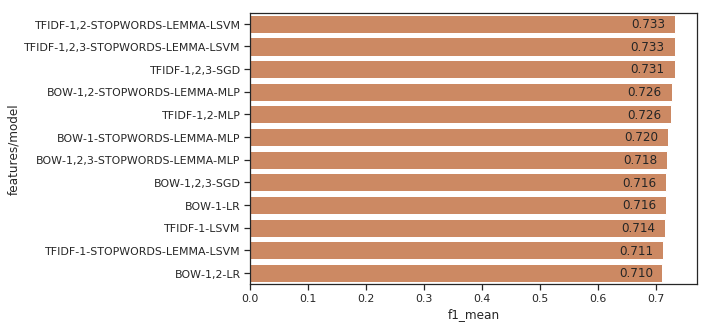

In [68]:
def adjustExp(string):
    string = string.upper()
    string = string.replace('UNIGRAM','1')
    string = string.replace('_BIGRAM',',2')
    string = string.replace('_TRIGRAM',',3')
    string = string.replace('PRE_PROCESSED','STOPWORDS-LEMMA')
    return string

metric = 'f1_mean'
df_best['features/model'] = df_best['experiment'] +['-']*len(df_best['model']) + df_best['model']
df_best['features/model'] = [adjustExp(t) for t in df_best['features/model']]
df_best = df_best.sort_values(by=metric,ascending=False)

keys = df_best['features/model']
values = df_best[metric]
sns.set(style="ticks")

plt.figure(figsize=(8, 5))
g = sns.barplot(x = values,y = keys,color='C1')

for p in g.patches:
    g.annotate(format(p.get_width(), '.3f'), (p.get_width()*0.90, 
                                               p.get_y() + p.get_height()/2.), ha = 'center', 
               va = 'center', xytext = (15, 0), textcoords = 'offset points')
    
# for p in g.patches:
#     g.annotate(format(p.get_width(), '.3f'), (p.get_y() + p.get_height() / 2., 
#                                                p.get_width()), ha = 'center', 
#                va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [45]:
df_best[['features/model','vocab','fpr_mean','pre_mean','rec_mean','f1_mean']][0:10] #.to_string(index=False))

,features/model,vocab,fpr_mean,pre_mean,rec_mean,f1_mean
0,tfidf-unigram_bigram-pre_processed-lsvm,129745,0.197,0.717,0.750,0.733
1,tfidf-unigram_bigram_trigram-pre_processed-lsvm,261665,0.211,0.692,0.778,0.733
2,tfidf-unigram_bigram_trigram-sgd,384783,0.212,0.692,0.777,0.731
3,bow-unigram_bigram-pre_processed-mlp,129745,0.173,0.781,0.679,0.726
4,tfidf-unigram_bigram-mlp,156182,0.197,0.722,0.731,0.726
5,bow-unigram-pre_processed-mlp,19455,0.182,0.760,0.685,0.720
6,bow-unigram_bigram_trigram-pre_processed-mlp,261665,0.172,0.795,0.657,0.718
7,bow-unigram_bigram_trigram-sgd,384783,0.198,0.725,0.710,0.716
8,bow-unigram-lr,23422,0.184,0.761,0.677,0.716
9,tfidf-unigram-lsvm,23422,0.197,0.726,0.704,0.714


In [52]:
dif = values.max()-values.min()
dif=dif*100/values.min()
print('%.3f'%dif)
values

3.224


0     0.733
1     0.733
2     0.731
3     0.726
4     0.726
5     0.720
6     0.718
7     0.716
8     0.716
9     0.714
10    0.711
11    0.710
Name: f1_mean, dtype: float64

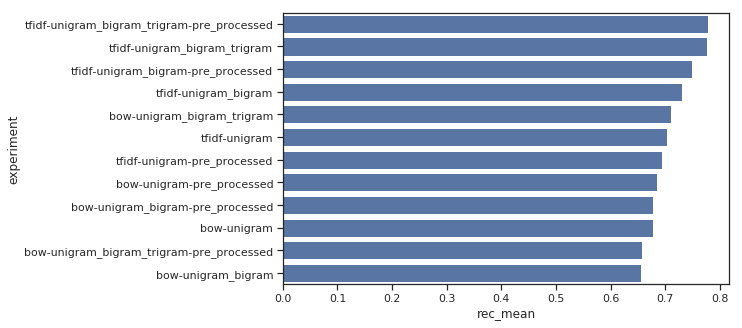

In [70]:
metric = 'rec_mean'
df_best = df_best.sort_values(by=metric,ascending=False)
x = df_best['experiment']
y = df_best[metric]
plt.figure(figsize=(8, 5))
sns.barplot(y,x,color='C0')

In [71]:
df_best['model'].value_counts()

mlp     4
lsvm    4
lr      2
sgd     2
Name: model, dtype: int64

In [72]:
print('total experiments:',len(df_best)*len(df_metrics))

total experiments: 108


# Error examples with best classifier

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       227
         1.0       0.78      0.78      0.78       111

    accuracy                           0.86       338
   macro avg       0.84      0.84      0.84       338
weighted avg       0.86      0.86      0.86       338

Total test data: 338
Negative in test data: 227
Positive in test data: 111
False negative:  24
False positive:  25


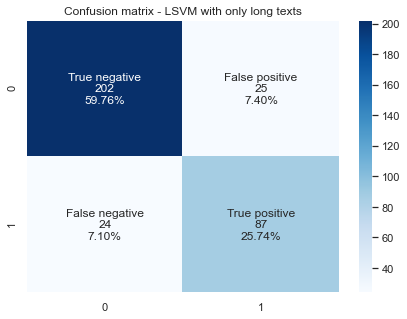

In [144]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
#clf = MLPClassifier(verbose=True, early_stopping= True, batch_size=64, n_iter_no_change = 5, tol = 1e-3).fit(X_train, y_train)
clf = LinearSVC(dual=False).fit(X_train, y_train)
y_pred = clf.predict(X_test)
#y_prob = clf.predict_proba(X_test)[:,1]
#getTestMetrics(y_test, y_pred, full_metrics = False, print_charts=True)

print(metrics.classification_report(y_test, y_pred))
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
group_names = ['True negative','False positive','False negative','True positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7, 5))
#plt.subplot(121)
plt.title('Confusion matrix - LSVM with only long texts')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


y_fails = y_test - y_pred
N = [index for index, value in enumerate(y_test) if value == 0]
P = [index for index, value in enumerate(y_test) if value == 1]
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

# 1 + 1 = 2 TP
# 0 + 0 = 0 TN
y_sucess = y_test + y_pred
TN = [index for index, value in enumerate(y_sucess) if value == 0]
TP = [index for index, value in enumerate(y_sucess) if value == 2]

print('Total test data:', len(y_pred))
print('Negative in test data:',len(N))
print('Positive in test data:',len(P))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

In [145]:
full_texts_test = list(full_texts_test)

In [146]:
texts_N = [full_texts_test[n] for n in N]
texts_P = [full_texts_test[p] for p in P]
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]
texts_TN = [full_texts_test[fn] for fn in TN]
texts_TP = [full_texts_test[fp] for fp in TP]

### False negative

In [147]:
for fn in texts_FN:
    print('***')
    print(fn)
    print('***')

***
Saiba quem é a Dr. *Nise Yamaguchi*, a médica chamada à Brasilia na última sexta-feira por Bolsonaro e que está à frente do tratamento por hidroxicloroquina de 400 pacientes com coronavírus, dos quais 200 já receberam alta e nenhum precisou ser internado.

_“Em duas semanas, nós mudamos completamente a realidade: de prontos-socorros apinhados e dezenas de mortes para uma situação próxima da normalidade. Nós não estávamos deixando de notificar as mortes, é que elas não estavam ocorrendo! Dra. Nise Yamaguchi”_

https://brasilsemmedo.com/dra-nise-e-a-batalha-para-salvar-o-brasil-do-virus/
***
***
Agora vc entende porque o número de mortes por coronavírus é TÃO GRANDE no estado de SP👇
***
***
https://www.defesa.tv.br/alfandega-dos-eua-apreendeu-amostras-de-virus-sars-mers-em-bagagens-de-chineses-em-2018-e-2019/
***
***
China e Rússia preparam-se para guerra contra o Ocidente, alerta analista 

 https://www.estudosnacionais.com/22963/china-e-russia-preparam-se-para-guerra-contra-o-ocide

### False positives

In [148]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
Ja estamos trabalhanfo igual a china
***


***
Para quem perdeu Guedes na XP, segue o link
https://www.youtube.com/watch?v=voghPHGSPms

Aqui vai um resumo dos principais pontos da fala do Ministro da Economia:

*Ministro da Economia, Paulo Guedes* 

*Destaques* 
-Nenhum brasileiro vai ficar para atrás
-Após 4-5 meses de crise, economia vai decolar 
-Injeção de BRL 800 na economia 


*Contexto*
Mundo estava desacelerando, panorama nacional é diferente. 

Aconteceram dois eventos que limitaram o crescimento da economia em 2019: Brumadinho e o colapso da economia Argentina, o que cortou crescimento no primeiro semestre, mas no segundo o crescimento já começou a acelerar novamente. 

A economia estava engatando quando chegou a calamidade do coronavirus. Estava tudo encaminhado para ser um semestre excepcional com reformas andando no Congresso. 

*Medidas*
Quando chegou o choque, meteoro que é o vírus, aprovamos serie de medidas para ajudar os estados e municípios, além de fortalecer o

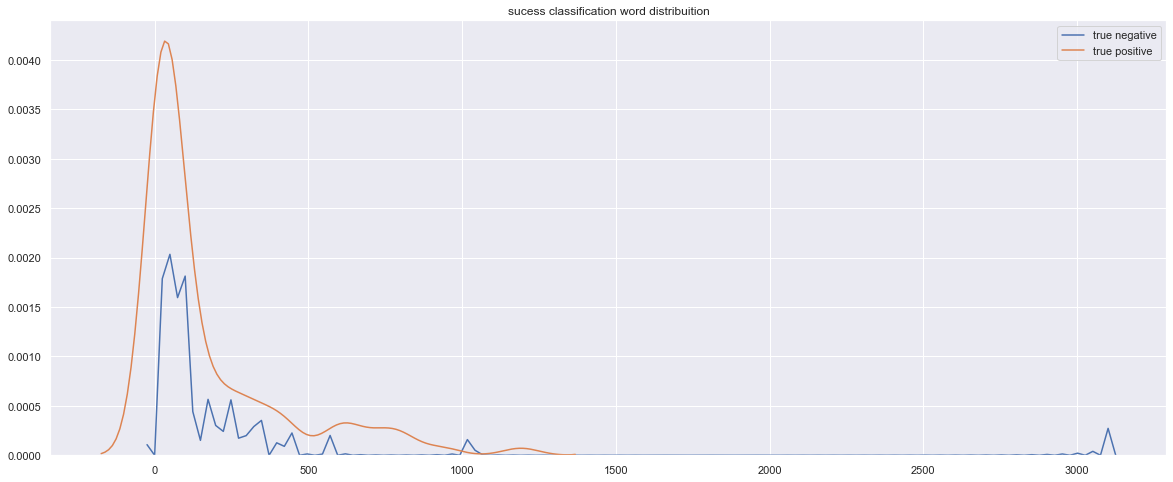

In [87]:
fn_tokens = np.array([len(t.split()) for t in texts_FN])
fp_tokens = np.array([len(t.split()) for t in texts_FP])
tn_tokens = np.array([len(t.split()) for t in texts_TN])
tp_tokens = np.array([len(t.split()) for t in texts_TP])
p_tokens = np.array([len(t.split()) for t in texts_P])
n_tokens = np.array([len(t.split()) for t in texts_N])

plt.figure(figsize=(20, 8))
plt.title('sucess classification word distribuition')
sns.distplot(tn_tokens, hist = False, kde = True, label = 'true negative')
sns.distplot(tp_tokens, hist = False, kde = True, label = 'true positive')
plt.show()


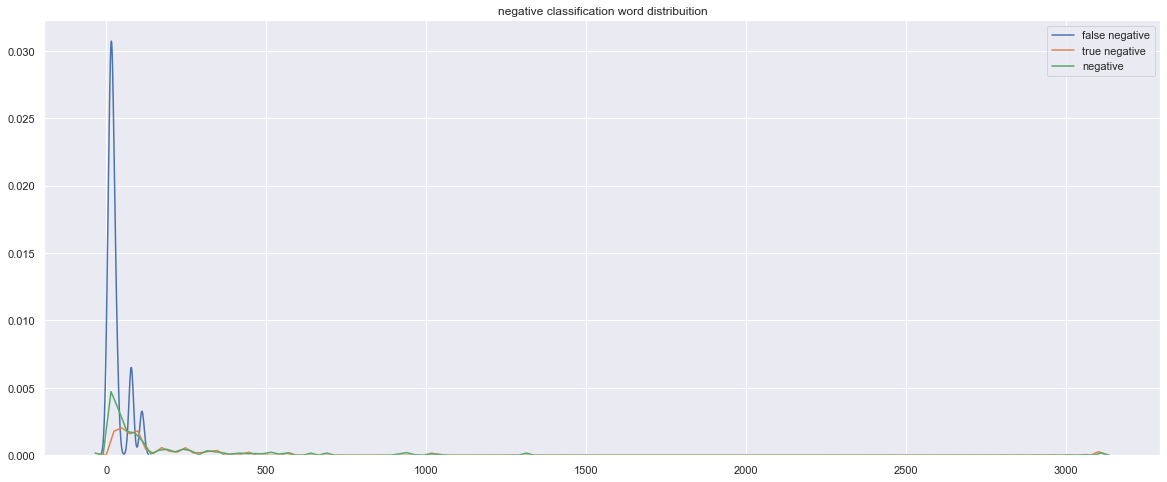

In [88]:
plt.figure(figsize=(20, 8))
plt.title('negative classification word distribuition')
sns.distplot(fn_tokens, hist = False, kde = True, label = 'false negative')
sns.distplot(tn_tokens, hist = False, kde = True, label = 'true negative')
sns.distplot(n_tokens, hist = False, kde = True, label = 'negative')
plt.show()

Negative class classification was very biased by size

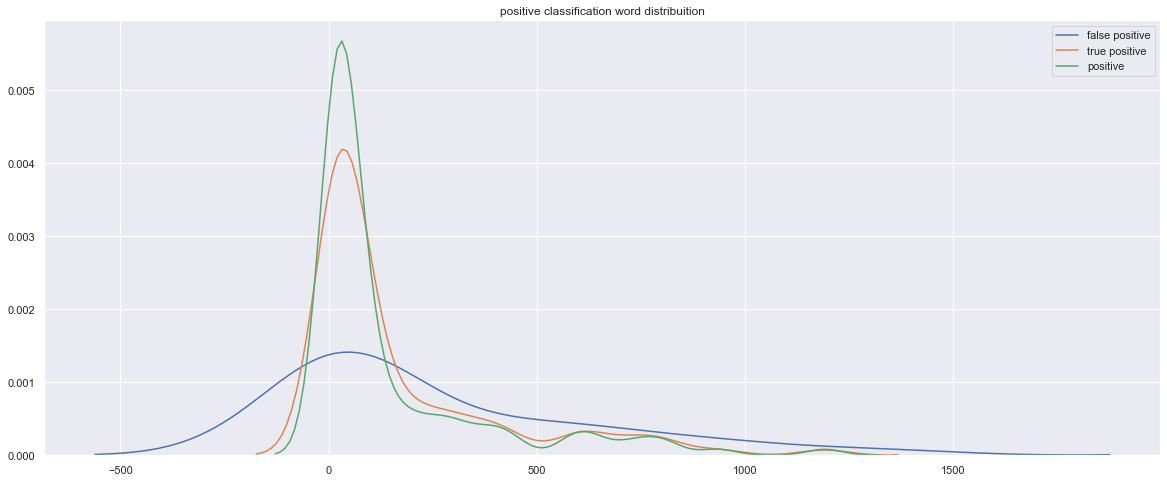

In [89]:
plt.figure(figsize=(20, 8))
plt.title('positive classification word distribuition')
sns.distplot(fp_tokens, hist = False, kde = True, label = 'false positive')
sns.distplot(tp_tokens, hist = False, kde = True, label = 'true positive')
sns.distplot(p_tokens, hist = False, kde = True, label = 'positive')
plt.show()

In [90]:
print()
print('false positive average tokens:',fp_tokens.mean())
print('true positive average tokens:',tp_tokens.mean())
print('positive average tokens:',p_tokens.mean())
print()
print('false negative average tokens:',fn_tokens.mean())
print('true negative average tokens:',tn_tokens.mean())
print('negative average tokens:',n_tokens.mean())


false positive average tokens: 257.14285714285717
true positive average tokens: 170.9468085106383
positive average tokens: 149.4144144144144

false negative average tokens: 30.352941176470587
true negative average tokens: 61.32673267326733
negative average tokens: 85.16521739130435


In [91]:
fn = ['false negative']*len(texts_FN)
fp = ['false positive']*len(texts_FP)

errors_text = texts_FN + texts_FP
errors_label = fn+fp
df_errors = pd.DataFrame({'text':errors_text,'error':errors_label})
len(df_errors)
#df_errors.to_csv('results/'+base+'/'+subset+'/errors/errors-mlp.csv')

45

In [92]:
len(df_errors)

45

# Qualitative analysis

In [95]:
# df_errors = pd.read_csv('results/2018/k-fold/errors/errors-lsvm-labels.csv')
# df_errors.head()

In [96]:
# total_fn = df_errors[df_errors['error']=='false negative']['type'].value_counts().sum()
# df_errors[df_errors['error']=='false negative']['type'].value_counts()/total_fn

In [97]:
# df_errors['type'] = [t if t != 'humour' else 'opinion' for t in df_errors['type']]
# df_errors['type'] = [t if t != 'prayer' else 'opinion' for t in df_errors['type']]
# df_errors['type'] = [t if t != 'alarmist' else 'short claim' for t in df_errors['type']]
# total_fp = df_errors[df_errors['error']=='false positive']['type'].value_counts().sum()
# df_errors[df_errors['error']=='false positive']['type'].value_counts()/total_fp #/len(df_errors)

In [98]:
# a = df_errors[(df_errors['error']=='false positive') & (df_errors['type']=='short claim')]['text']
# list(a)